In [ ]:
pip install pyspark

In [3]:


import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, max, min, countDistinct, sum, round

In [4]:
## Set up PySpark environment
from pyspark.sql import SparkSession

In [5]:
## Initialize the SparkSession
# appName is the name of the application
# getOrCreate() creates a new session or retrieves an existing one
spark = SparkSession.builder \
    .appName("ZipCode PySpark Learning") \
        .getOrCreate()

## Verify that SparkSession is created
spark

25/04/18 14:42:35 WARN Utils: Your hostname, Zipcoders-MacBook-Pro-6.local resolves to a loopback address: 127.0.0.1; using 192.168.3.107 instead (on interface en0)
25/04/18 14:42:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 14:42:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/18 14:42:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:

## Read the CSV file into a DataFrame
df = spark.read.csv("/Users/angel/Desktop/Python_Projects/ExploreZipCodeData_PySpark/data/zip_code_demographics.csv", header=True, inferSchema=True)

In [9]:
df.show()

+----+--------+---------+---------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
| zip|     lat|      lng|           city|state_id|   state_name|population|density|county_name|po_box|      dist_highway|dist2_large_airport|dist2_medium_airport|   dist_to_shore|number_of_business|adjusted_gross_income|total_income_amount|number_of_returns|
+----+--------+---------+---------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
|1001|42.06262|-72.62521|         Agawam|      MA|Massachusetts|     16088|  550.1|    Hampden|     0|  1.38703489958776|   106.145765467407|    12.9462123500772|93.0492507357679|               438|               598807|   

In [10]:
#attributes of the dataframe
df.columns

['zip',
 'lat',
 'lng',
 'city',
 'state_id',
 'state_name',
 'population',
 'density',
 'county_name',
 'po_box',
 'dist_highway',
 'dist2_large_airport',
 'dist2_medium_airport',
 'dist_to_shore',
 'number_of_business',
 'adjusted_gross_income',
 'total_income_amount',
 'number_of_returns']

In [12]:
#size of dataframe
print((df.count(), len(df.columns)))

(33704, 18)


## Top 10 Cities Closest to the Shore Ranked By # of Business

In [21]:
#Creating a new DataFrame with the needed columns
sho_df = df[['state_id', 'city', 'number_of_business', 'dist_to_shore']]
sho_df.show()

+--------+---------------+------------------+----------------+
|state_id|           city|number_of_business|   dist_to_shore|
+--------+---------------+------------------+----------------+
|      MA|         Agawam|               438|93.0492507357679|
|      MA|        Amherst|               571|133.370143966814|
|      MA|          Barre|                97|97.6398810953817|
|      MA|    Belchertown|               217|114.406033754504|
|      MA|      Blandford|                18|107.466779445914|
|      MA|      Brimfield|                73|94.9280235181023|
|      MA|        Chester|                13|128.563170400209|
|      MA|   Chesterfield|                10|137.693284947624|
|      MA|       Chicopee|               317|104.576258028243|
|      MA|       Chicopee|               550|105.789420653597|
|      MA|       Chicopee|                63|107.544849378402|
|      MA|     Cummington|                18|147.638866780228|
|      MA|    Easthampton|               372| 124.36751

 Clearning up the data -- combining rows and rounding long decimals

In [ ]:
# from pyspark.sql.functions import concat, lit

# #Combining city and state_id
# combined_sho_df = sho_df.select(concat(col('city'), lit(', '), col('state_id')))
# combined_sho_df.show()

+--------------------------+
|concat(city, , , state_id)|
+--------------------------+
|                Agawam, MA|
|               Amherst, MA|
|                 Barre, MA|
|           Belchertown, MA|
|             Blandford, MA|
|             Brimfield, MA|
|               Chester, MA|
|          Chesterfield, MA|
|              Chicopee, MA|
|              Chicopee, MA|
|              Chicopee, MA|
|            Cummington, MA|
|           Easthampton, MA|
|       East Longmeadow, MA|
|         Feeding Hills, MA|
|          Gilbertville, MA|
|                Goshen, MA|
|                Granby, MA|
|             Granville, MA|
|                Hadley, MA|
+--------------------------+
only showing top 20 rows



In [ ]:
#Rounding dist_to_shore to 2 decimal places
sho_df = sho_df.withColumn('dist_to_shore', round('dist_to_shore', 2))
sho_df.show(10)

+--------+------------+------------------+-------------+
|state_id|        city|number_of_business|dist_to_shore|
+--------+------------+------------------+-------------+
|      MA|      Agawam|               438|        93.05|
|      MA|     Amherst|               571|       133.37|
|      MA|       Barre|                97|        97.64|
|      MA| Belchertown|               217|       114.41|
|      MA|   Blandford|                18|       107.47|
|      MA|   Brimfield|                73|        94.93|
|      MA|     Chester|                13|       128.56|
|      MA|Chesterfield|                10|       137.69|
|      MA|    Chicopee|               317|       104.58|
|      MA|    Chicopee|               550|       105.79|
+--------+------------+------------------+-------------+
only showing top 10 rows



In [28]:
#dropping duplicates and sort by distance to shore
unique_sho_df = sho_df.dropDuplicates()
print((unique_sho_df.count(), len(unique_sho_df.columns)))


(33671, 4)


In [ ]:
#sort dataset closest to farthest to shore
sorted_sho_df = unique_sho_df.sort(col('dist_to_shore').asc())
top_10_cities = sorted_sho_df.limit(10)
top_10_cities.show()

+--------+----------+------------------+-------------+
|state_id|      city|number_of_business|dist_to_shore|
+--------+----------+------------------+-------------+
|      MI| Luna Pier|                12|         0.01|
|      FL|   Captiva|                89|         0.01|
|      WA|Bellingham|              1993|         0.02|
|      ME| Matinicus|                69|         0.02|
|      AK|Petersburg|               147|         0.02|
|      FL|  Key West|              1546|         0.07|
|      MD|     Issue|                 8|         0.09|
|      ME|    Sunset|                 7|          0.1|
|      NC|  Ocracoke|                18|          0.1|
|      NJ| Highlands|                86|         0.14|
+--------+----------+------------------+-------------+



In [42]:
#plotting the dataframe
top_10_cities_df = top_10_cities.toPandas()
top_10_cities_df.head()

,state_id,city,number_of_business,dist_to_shore
0,MI,Luna Pier,12,0.01
1,FL,Captiva,89,0.01
2,WA,Bellingham,1993,0.02
3,ME,Matinicus,69,0.02
4,AK,Petersburg,147,0.02


In [49]:
# Combining columns after ensuring compatibility
top_10_cities_df['city'] = top_10_cities_df['city'] + ', ' + top_10_cities_df['state_id']
top_10_cities_df.head()

,state_id,city,number_of_business,dist_to_shore
0,MI,"Luna Pier, MI",12,0.01
1,FL,"Captiva, FL",89,0.01
2,WA,"Bellingham, WA",1993,0.02
3,ME,"Matinicus, ME",69,0.02
4,AK,"Petersburg, AK",147,0.02


In [50]:
#drop state column
top_10_cities_df = top_10_cities_df.drop('state_id', axis=1)
top_10_cities_df

,city,number_of_business,dist_to_shore
0,"Luna Pier, MI",12,0.01
1,"Captiva, FL",89,0.01
2,"Bellingham, WA",1993,0.02
3,"Matinicus, ME",69,0.02
4,"Petersburg, AK",147,0.02
5,"Key West, FL",1546,0.07
6,"Issue, MD",8,0.09
7,"Sunset, ME",7,0.10
8,"Ocracoke, NC",18,0.10
9,"Highlands, NJ",86,0.14


In [51]:
ranked_by_biz = top_10_cities_df.sort_values(by='number_of_business', ascending=False)
ranked_by_biz

,city,number_of_business,dist_to_shore
2,"Bellingham, WA",1993,0.02
5,"Key West, FL",1546,0.07
4,"Petersburg, AK",147,0.02
1,"Captiva, FL",89,0.01
9,"Highlands, NJ",86,0.14
3,"Matinicus, ME",69,0.02
8,"Ocracoke, NC",18,0.10
0,"Luna Pier, MI",12,0.01
6,"Issue, MD",8,0.09
7,"Sunset, ME",7,0.10


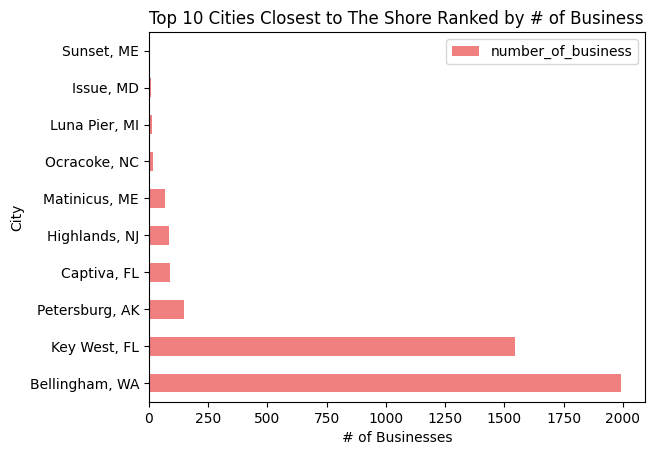

In [ ]:
#plotting the dataframe
ranked_by_biz.plot.barh(x='city', y='number_of_business', color='lightcoral')
plt.xlabel('# of Businesses')
plt.ylabel('City')
plt.title('Top 10 Cities Closest to The Shore Ranked by # of Business')
plt.show()

## number of returns by county

## Distance highway/airport Pop by zipcode